In [1]:
# Jupyter options
%load_ext autoreload
%autoreload
%config IPCompleter.greedy=True

# Some basic imports to use
import tensorflow_datasets as tfds
import tensorflow.compat.v2 as tf
import numpy as np
import random
from tensorflow import keras
import matplotlib.pyplot as plt

# Just set some seeds so we are consistent across runs
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

# tfds works in both Eager and Graph modes
# just really make sure we are in the correct tensorflow mode
tf.compat.v1.enable_eager_execution()

tf.compat.v1.random.set_random_seed(random_seed) # just so it is forward compatible
print(tf.version.VERSION)

2.0.2


# Data loading
We are going to use the [Dogs vs Cats Dataset from Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765), and use the [Tensorflow catalog to load them](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs)

In [2]:
# train is the only split that exists
# label 1 is dog, 0 is cat

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

# Data Analysis

Label: cat tensor: (360, 400, 3)
Label: dog tensor: (500, 375, 3)


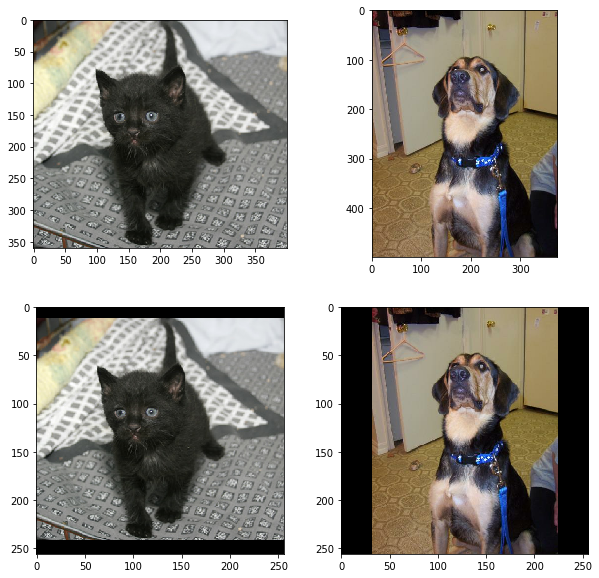

In [3]:
%matplotlib inline
# we shuffle the data here without seed so it changes everytime you run
fig = plt.figure(figsize=(10, 10))

img_size = 256
for i, sample in enumerate(raw_train.shuffle(128).take(2)):
    
    image, label = sample[0], sample[1]
    print("Label: {} tensor: {}".format(metadata.features['label'].int2str(label), image.shape))
    fig.add_subplot(2, 2, i+1)
    plt.imshow(image)

    image = tf.image.resize_with_pad(
        image,
        img_size,
        img_size,
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
        #antialias=True
    )  
    image = tf.cast(image, dtype=tf.uint8)
    
    fig.add_subplot(2, 2, i+3)
    plt.imshow(image)
    
    # We also need to check the shape of the tensor
    

plt.show()

In [4]:
# Resize all the images so they are the same
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    """
    Rescale image to IMG_SIZE and move range of values to [-1, 1]
    """
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

#image_label_batch = train_batches.take(1)

# Create Model

(None, 5, 5, 1280)


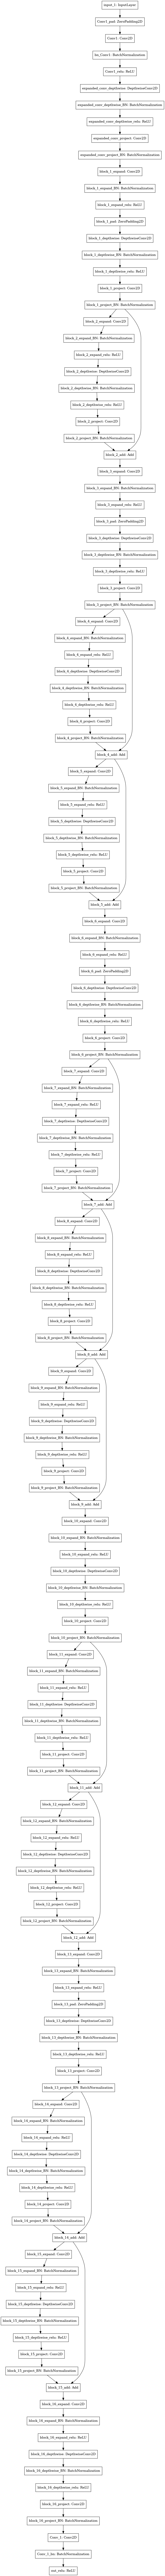

In [5]:
# Let's actually create a model now
'''
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
'''
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

#By specifying the include_top=False argument, 
#we load a network that doesn't include the classification layers at the top, 
#which is ideal for feature extraction.
base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
#print(base_model.summary())
print(base_model.layers[-1].output_shape)

# Freeze the model as we don't want to train this one anymore
base_model.trainable = False
keras.utils.plot_model(base_model)


In [6]:
# Now we can create a model which uses the pretrained one and targets the output we want
model = tf.keras.Sequential([
  base_model, # pretrained model
  keras.layers.GlobalMaxPool2D(), # move all the Conv2d features into a single vector
  keras.layers.Dense(1) # Activate on dog/cat
])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [7]:
# Do some inital evaluation
initial_epochs = 10
validation_steps=20
# initial use will probably we terrible
#loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)


# Model Run

In [8]:
from datetime import datetime


logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(train_batches,
                    epochs=3,
                    validation_data=validation_batches,
                   callbacks=[tensorboard_callback])
model.save("dog_cat_imagenet_keras_saved")

Epoch 1/3
582/582 [==============================] - 47s 80ms/step - loss: 0.5728 - accuracy: 0.7822 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/3
582/582 [==============================] - 29s 49ms/step - loss: 0.2719 - accuracy: 0.8955 - val_loss: 0.1627 - val_accuracy: 0.9334
Epoch 3/3
582/582 [==============================] - 29s 49ms/step - loss: 0.2267 - accuracy: 0.9146 - val_loss: 0.1482 - val_accuracy: 0.9407
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: dog_cat_imagenet_keras_saved/assets


INFO:tensorflow:Assets written to: dog_cat_imagenet_keras_saved/assets


# Model Performance

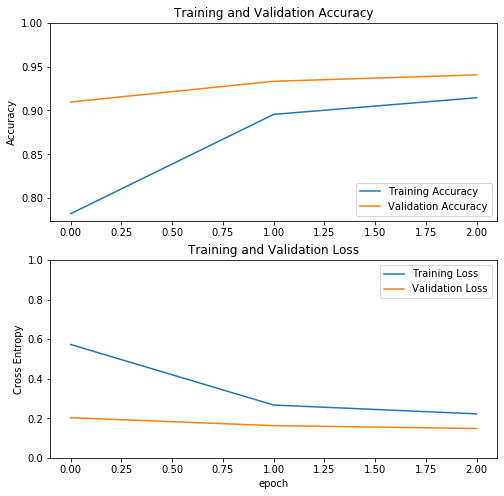

In [9]:
import pandas as pd

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


# Model Analysis

In [10]:
for image in train.shuffle(1000).take(1):
    #print((image[0]))
    inputToLayer = tf.reshape(image[0], (1, 160, 160, 3))
    inputToLayer = base_model.call(inputToLayer)
    '''
    for l in base_model.layers[:3]:
        inputToLayer = l.call(inputToLayer)
        print(inputToLayer.shape)
    '''
keras.layers.GlobalMaxPool2D().call(inputToLayer)

<tf.Tensor: id=50415, shape=(1, 1280), dtype=float32, numpy=
array([[0.       , 0.       , 6.       , ..., 5.752354 , 0.       ,
        2.1006503]], dtype=float32)>

In [11]:

#plt.ioff()
for i, image in enumerate(tf.unstack(inputToLayer, axis=-1)[:5]):
    #image = tf.multiply(image, 255)
    #image = tf.cast(image, dtype=tf.uint8)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    plt.imshow(image[0], cmap="Greys")
    #fig.savefig('base_model_out/{}.png'.format(i))
    plt.close(fig)
    
    #print(image)
#plt.close(fig)b

In [4]:
if model == None:
    model = tf.keras.models.load_model("dog_cat_imagenet_keras_saved")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) multiple                  2257984   
_________________________________________________________________
global_max_pooling2d (Global multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________
